# Low level Tensorflow model for MNIST/CIFAR10 classification
Ok, I understand that there are many really good Tensorflow tutorials out there. I have completed a couple myself. Particularly, I cannot recommend enought those from Stanford CS231n and Andrew Ng's Deep Learning Coursera. However, when I tried to create my first own project from scratch I found myself having to look for help in my previous sample homeworks from CS231n and Coursera. Thus, I decided that to get a real understanding of Tensorflow, I had to complete some projects from zero, without any sort of template.
Although this notebook is quite a selfish project to improve my proficiency, I reckon it may be of use to at least one individual out there in a similar situation, so feel free to use this code.
For familiriaty, I will be using the ever useful MNIST database of handwritten characters.
Please note that this Notebook assumes Deep Learning Understanding at a level of the courses mentioned above, as well as python, and is only a Tensorflow getting started tutorial from scratch.
Also, please note that this notebook is the first of a 3-part series, the other two series will use CNNs and CIFAR10.


In [1]:
# Import all the libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

## Importing and preprocessing the data
As mentioned before, I will be using MNIST and CIFAR10 for this notebook. 
We can use Tensorflow-Keras with the command 'tf.keras.datasets.mnist.load_data()' and download the database online, or we can download it from:
https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz
For more detailed information on the MNIST dataset, please refer to [LeCun et al., 1998a] Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. "Gradient-based learning applied to document recognition." Proceedings of the IEEE, 86(11):2278-2324, November 1998. Also please see http://yann.lecun.com/exdb/mnist/

In a second experiment, we will use the CIFAR10 dataset, which we will download from Alex Krizhevsky website at University of Toronto at https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
For more details of the CIFAR10, dataset please refer to https://www.cs.toronto.edu/~kriz/cifar.html or 
Krizhevsky, A., "LearningMultipleLayersofFeaturesfromTinyImages", 2009, https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf

In [2]:
# Uncomment to use MNIST
#(x_train, y_train), (x_test, y_test)= tf.keras.datasets.mnist.load_data()

# Uncomment to use CIFAR10
(x_train, y_train), (x_test, y_test)= tf.keras.datasets.cifar10.load_data()


# Define dataset to use
if x_test.shape[1] == 28:
    dataset = 'MNIST'
    PIXELS = 784
else:
    dataset = 'CIFAR10'
    PIXELS = 3072

In [3]:
# It is a good idea to visualise the data we just loaded.
print('Train data shape: ', x_train.shape)
print('Train labels shape: ', y_train.shape)
print('Test data shape: ', x_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (50000, 32, 32, 3)
Train labels shape:  (50000, 1)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000, 1)


Train image shape:  (32, 32, 3)


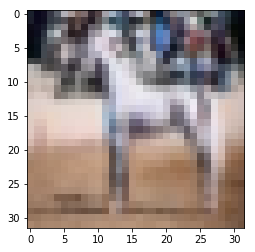

In [4]:
# So, as expected we have 60,000 training images and 10,0000 for testing. What is
# each image shape? Let's find out
print('Train image shape: ', x_train[1].shape)

# Knowing it is a matrix shape, we can randomly show any of the numbers
rnd_idx = np.random.randint(x_train.shape[0])
plt.imshow(x_train[rnd_idx].astype(np.int32)) #Using astype guarantess imshow work

In [5]:
# For simplicity and to use default TF settings, we cast the data to int32 and float32
# Since, the dataset is relatively small, in most cases, this is not a problem
y_train = y_train.astype(np.int32).reshape(-1)
y_test = y_test.astype(np.int32).reshape(-1)
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

In [6]:
# Check data types, not necessary, perhaps educational
type(y_train)
isinstance(y_test, np.ndarray) #validate if it is 

True

In [7]:
# Validate data are numpy arrays
assert (isinstance(x_train, np.ndarray) and isinstance(y_train, np.ndarray)), 'No ndarray'

In [8]:
# Here we define a function to divide our data in N mini batches, this is an important step, to allow for mini batch 
# gradient descent

def mini_batches(mini_batch_size, data_x, data_y = None):
    # First we validate the data is of the expected type, and the number of labels meet the number of training samples
    assert data_x.shape[0] == data_y.shape[0], 'X number of samples not equal to Y number of samples'
    assert (isinstance(data_x, np.ndarray) and isinstance(data_y, np.ndarray)), 'Data not numpy array'
    
    N = data_x.shape[0] # Get the number of samples
    idxs = np.arange(N) 
    # Shuffle data, this may not be so critical in this example, but it is important for most applications, to avoid
    # strong correlations in mini batches
    np.random.shuffle(idxs)
    data_x = data_x[idxs] # Shuffle training samples
    data_y = data_y[idxs] # Shuffle labels (don't forget)
    
    # Finally return the data in minibatches of the desired size
    # List comprehension is so cool, technically this is returning a generator but the principle is the same
    return ((data_x[i:i+mini_batch_size], data_y[i:i+mini_batch_size]) for i in range(0, N, mini_batch_size))

type(mini_batches(64, x_test, y_test)) # Check type returned by function

generator

In [9]:
x_train[:1].shape # In case we need to check the shape of one sample

(1, 32, 32, 3)

In [10]:
# if using list comprehension instead of generator
# a = mini_batches(500, x_test, y_test)
# print((a[5][0].shape))

In [11]:
# To iterate through the data, we use something like this
for t,(x,y) in enumerate(mini_batches(64, x_train, y_train)):
    print(t, x.shape, y.shape) # Print the shape for each minibatch
    if t > 8:
        break # Stop after the first 10 minibatches

0 (64, 32, 32, 3) (64,)
1 (64, 32, 32, 3) (64,)
2 (64, 32, 32, 3) (64,)
3 (64, 32, 32, 3) (64,)
4 (64, 32, 32, 3) (64,)
5 (64, 32, 32, 3) (64,)
6 (64, 32, 32, 3) (64,)
7 (64, 32, 32, 3) (64,)
8 (64, 32, 32, 3) (64,)
9 (64, 32, 32, 3) (64,)


## Start with tensorflow training

In this notebook I show a very low level implementation, well not really I'm using Tensorflow, but still low level given TF standards. I reckon this is intuitive and shows what is going on, facilitating the transition to higher level TF and Keras in more complex projects.

The approach followed in this notebook is to use functions to define the network architecture, and parameter initialization, as shown in the next cell

In [12]:
# First, let's define the architecture of our FC networks.
# I will start with a 4-Layer vanilla (tasty) FC NN with ReLu activations, weight decay regularization (L2),
# using the number of hidden units given in, well, hidden_units


def init_four_layer_FC(PIXELS, hidden_units):
    '''
    Initialise the parameters

    Inputs:
    - PIXELS: Scalar with total number of pixels in the image (for MNIST that would be 28x28 = 784)
    - hidden_units: List with number of hidden neurons per layer

    Outputs:
    - Parameters: List with network parameters
    '''
    # Extract layer sizes
    H1 = hidden_units[0]
    H2 = hidden_units[1]
    H3 = hidden_units[2]
    classes = hidden_units[3]

    #     Given that we only have 4 layers initializing with small random numbers should be fine, however we could
    #     use a more roburs initialization like that in:   
    #     He et al, *Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification,
    #     ICCV 2015, https://arxiv.org/abs/1502.01852
    #     For example:
    '''
    w1 = tf.Variable(tf.random_normal(
                             (PIXELS, hidden_units1), dtype=tf.float32) * np.sqrt(2.0 / PIXELS), 
                             dtype=tf.float32)
    '''
    # First, let's define the weights, we use variables because they are maintained in the graph and can be 
    # mutated through iterations. If we manually declare the learnable weights, tf.Variables are usally the ones
    # to use

    # Define 1st layer parameters, note that tf.float32 is the default type, however I leave explicit in case
    # we wanted to use different type of data for particular purposes

    # Weights are left as normal random with std = 0.01 and mean = 0
    # Biases are set to zero
    # Since they are learnable parameters they are set to zero

    w1 = tf.Variable(tf.random_normal((PIXELS, H1), dtype=tf.float32) * 0.01, dtype=tf.float32, name='w1')
    b1 = tf.Variable(tf.zeros(H1, dtype=tf.float32), dtype=tf.float32, name='b1')

    w2 = tf.Variable(tf.random_normal((H1, H2), dtype=tf.float32) * 0.01, dtype=tf.float32, name='w2')
    b2 = tf.Variable(tf.zeros(H2, dtype=tf.float32), dtype=tf.float32, name='b2')

    w3 = tf.Variable(tf.random_normal((H2, H3), dtype=tf.float32) * 0.01, dtype=tf.float32, name='w3')
    b3 = tf.Variable(tf.zeros(H3, dtype=tf.float32), dtype=tf.float32, name='b3')

    w4 = tf.Variable(tf.random_normal((H3, classes), dtype=tf.float32) * 0.01, dtype=tf.float32, name='w4')
    b4 = tf.Variable(tf.zeros(classes, dtype=tf.float32), dtype=tf.float32, name='b4')

    # Return parameters
    parameters = [w1, b1, w2, b2, w3, b3, w4, b4]

    return parameters

def four_layer_FC(PIXELS,x, parameters,dataset):
    '''
    Create the inference graph, define the network architecture
    
    Inputs:
    - PIXELS: Scalar with total number of pixels in the image (for MNIST that would be 28x28 = 784)
    - x: Tensor with training or test images of shape (N, 28, 28) for MNIST
    - parameters: Tuple with all the learnable weights and biases
    
    '''
    
    # Verify that x Dimensions match 
    if dataset == 'MNIST':
        assert x.shape[1] * x.shape[2] == PIXELS, 'Image dimensions not as expected'
    else:
        assert x.shape[1] * x.shape[2] * x.shape[3] == PIXELS, 'Image dimensions not as expected'
    # Extract learning parameters
    w1, b1, w2, b2, w3, b3, w4, b4 = parameters
    # Implement architecture
    x = tf.reshape(x,(-1, PIXELS))
    
    h1 = tf.matmul(x, w1) + b1
    a1 = tf.nn.relu(h1)
    
    h2 = tf.matmul(a1, w2) + b2
    a2 = tf.nn.relu(h2)
    
    h3 = tf.matmul(a2, w3) + b3
    a3 = tf.nn.relu(h3)
    
    scores = tf.matmul(a3, w4) + b4

    return scores
   

It is important to be sure that the model produces an expected output for a given input. Thus, the following step just veryfies that running data through produces a tensor of the expected shape.

In [13]:
# Help function to test if the inference graph produces the expected output dimensions given an input
# in this case the output should be of shape (N, 10)

def test_FC(num_samples, dataset):
    # Let us declare some useful constants
    if dataset == 'MNIST':
        PIXELS = x_test.shape[1] * x_test.shape[2]
    elif dataset == 'CIFAR10':
        PIXELS = x_test.shape[1] * x_test.shape[2] * x_test.shape[3]
    hidden_units = [100, 100, 100, 10]
    
    # Reset the default graph
    tf.reset_default_graph()
    
    # Define placeholder
    if dataset == 'MNIST':
        x = tf.placeholder(tf.float32, [None, 28, 28])
    else:
        x = tf.placeholder(tf.float32, [None, 32, 32, 3])
    
    # Obtain parameters
    parameters = init_four_layer_FC(PIXELS, hidden_units)
    
    # Add scores to the graph
    scores = four_layer_FC(PIXELS, x, parameters, dataset)
    
    # Create session and run it
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        test = sess.run(scores, feed_dict={x:x_train[:num_samples]})
        print(test.shape)

# Test our model output size
test_FC(10, dataset)

Instructions for updating:
Colocations handled automatically by placer.
(10, 10)


## Build the training model
In this point we will start training our graph. For this we will use a Tensorflow session to run the inference graph and the training operations. This will look similiar to test_FC(), plus the required components to define a loss function and carry out learning step operations. For simplicity let us use vanilla Gradient Descent.

In [14]:
# This function defines the complete training graph

def train_FC_model(hidden_units, 
                   num_epochs=10,
                   PIXELS=784,
                   learning_rate=0.05,
                   reg=0,
                   print_every=100,
                   minibatch_size = 64):
    '''
    Train Tensorflow model
    
    Inputs:
    - hidden_units: List with number of hidden neurons per layer
    - num_epochs: Integer with the number of epochs to run, an epoch is a complete pass in the whole training set
    - PIXELS: Scalar with total number of pixels
    - learning_rate: Float with the learning rate to use for updates, i.e. the step size towards the minimum
    - reg: L2 regularization strength, default is set to 0 for no regularization
    - print_every: This is a helping variable to stop during training and evaluate loss functions and accuracy
    - minibatch_size: Integer with the number of elements in minibatch
    
    Outputs:
    - updated_parameters: List with update parameters
    '''


    # Reset default graph.
    tf.reset_default_graph()
    
    # Define training data placeholders using expected MNIST data dimensions
    if dataset == 'MNIST':
        x = tf.placeholder(tf.float32, [None, 28, 28], name = 'x_train') # Training data
        y = tf.placeholder(tf.int32,[None, ], name='y_train') # Labels
    elif dataset == 'CIFAR10':
        x = tf.placeholder(tf.float32, [None, 32, 32, 3], name = 'x_train') # Training data
        y = tf.placeholder(tf.int32, [None, ], name = 'y_train') # Training data
    
    
    
    # Add these placeholders to graph in saver, this will allow for easy model restore
    tf.add_to_collection('images', x)
    tf.add_to_collection('labels', y)

    # Load parameters by running the previously defined function
    parameters = init_four_layer_FC(PIXELS, hidden_units)
    
    # Add scores to graph using the function we coded, and the parameters
    scores = four_layer_FC(PIXELS, x, parameters, dataset)
    
    # Save scores to model, this is key since it will allow using it for inference after restore
    tf.add_to_collection('scores', scores)
    
    # Once the scores are computed, we need to obtain our Loss. Given the data, we will use Cross entropy 
    # Using Tensorflow implementation of Cross entropy
    losses = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=scores, labels=y) # Each sample loss
    data_loss = tf.reduce_mean(losses, name='loss') # take minibatch average
    
    # Should we want to use l2 regularization, default is zero, i.e., no regularization
    reg_loss = tf.reduce_mean(reg * (tf.nn.l2_loss(parameters[0])
                                     + tf.nn.l2_loss(parameters[2])
                                     + tf.nn.l2_loss(parameters[4])
                                     + tf.nn.l2_loss(parameters[0])))
    
    loss = data_loss + reg_loss # Compute total loss
    
    # Up to this point we have computed the complete forward pass of the data. 
    # Since, this is 'low level' Tensorflow we need to compute the gradients for the loss 
    # w.r.t. all the learnable parameters. As I said, low level but still Tensorflow. So let's use tf.gradients!
    grad_parameters = tf.gradients(loss, parameters) # Loss gradient w.r.t. parameters

    # We need to update the weights manually, for this we can use tf.assign, or tf.assing_sub
    # Using SGD, we need to update each parameter independently, so list comprehension works well
    updated_parameters = [tf.assign_sub(w, learning_rate * grad)
                          for w, grad in zip(parameters, grad_parameters)]
    
    tf.add_to_collection('weights', updated_parameters)
    
    accuracies = np.zeros(10) # Helping variable to store accuracies
    losses = np.zeros(10) # Helping variable to store accuracies
    
    # Create saver to save the model
    saver = tf.train.Saver()
    # Now, recall we have only created the graph, in order to run it and train, we need a Session
    with tf.Session() as sess:
        # Initialise variables
        sess.run(tf.global_variables_initializer())
        
        # Train the model for num_epochs
        for epoch in range(num_epochs):
            
            print('Epoch number: ', epoch) # Allow us to see what epoch we are running
            
            # Run the necessary iterations given the number of minibatches, this follows the function defined
            # at the beginning of the notebook
            for iteration,(x_mb, y_mb) in enumerate(mini_batches(minibatch_size, x_train, y_train)):
                # The following line calculates the loss for the minibatch.
                # Recall TF knows what is needed to run a function and will run accordinly, e.g. scores before the
                # loss. Also note that we only need to feed the data needed into a placeholder. In this case, we 
                # feed the minibatch training samples and labels
                loss_mb, update_param = sess.run([loss, updated_parameters], feed_dict={x:x_mb, y:y_mb})
                
                # The following condition allows a sanity check by printing accuracies and loss
                if iteration % print_every == 0:
                    # We define this function in the next cell
                    accuracy = compute_accuracy(sess, minibatch_size, scores, x)
                    accuracies[int(iteration/100)]=accuracy # save current accuracy
                    losses[int(iteration/print_every)] = loss_mb
                    print('Iteration: %d Loss: %f Accuracy: %f Learning rate: %f'
                          %(iteration, loss_mb, accuracy, learning_rate))
        
        # We could use learning rate decay. There are several conditions we could test to define when to decay.
        # E.g. we could use it when accuracy is over e.g. 90%, or the loss stays relatively flat
            print('Last losses std: ', np.std(losses))
            if np.std(losses) < 0.80:
                learning_rate = 0.95 * learning_rate
        # Save the 
        saver.save(sess, 'checkpoint_file')
        
    return update_param

In [15]:
def compute_accuracy(sess, minibatch_size, scores, x):
    '''
    This function computes the accuracy of the current model
    
    Inputs:
    - sess: it needs a current tf.Session to run the scores
    - minibatch_size: The size of the mini batch to run the scores
    - scores: TF operation to run
    - x: test data
    
    Outputs:
    - acc: Accuracy
    
    '''
    num_samples = 0
    num_correct = 0
    for it, (xtest_mb, ytest_mb) in enumerate(mini_batches(minibatch_size, x_test, y_test)):
        scores_test = sess.run(scores, feed_dict={x:xtest_mb})
        y_pred = np.argmax(scores_test, axis=1)

#         In case we would like to compare some elements of the predicted and ground truth arrays
#         if it % 200 == 0:
#             print('y_pred: ', y_pred[:10])
#             print('y_test: ', ytest_mb[:10])

        num_samples += xtest_mb.shape[0]
        num_correct += np.sum(np.equal(y_pred, ytest_mb))
    acc = float(num_correct) / num_samples
    return acc

In [16]:
# Define number of neurons (units) in each hidden layer
hidden_units = [100, 100, 100, 10]

# Train the model and save weights
updated_parameters =  train_FC_model(hidden_units=hidden_units, 
                                     num_epochs=20,
                                     PIXELS=PIXELS, 
                                     learning_rate=0.005,
                                     minibatch_size=128,
                                     reg= 0.0, 
                                     print_every=100)

Epoch number:  0
Iteration: 0 Loss: 2.304721 Accuracy: 0.103000 Learning rate: 0.005000
Iteration: 100 Loss: 2.224907 Accuracy: 0.137600 Learning rate: 0.005000
Iteration: 200 Loss: 2.057334 Accuracy: 0.225600 Learning rate: 0.005000
Iteration: 300 Loss: 2.018455 Accuracy: 0.261000 Learning rate: 0.005000
Last losses std:  1.056570604110854
Epoch number:  1
Iteration: 0 Loss: 1.878428 Accuracy: 0.289400 Learning rate: 0.005000
Iteration: 100 Loss: 1.982928 Accuracy: 0.268200 Learning rate: 0.005000
Iteration: 200 Loss: 1.862534 Accuracy: 0.318100 Learning rate: 0.005000
Iteration: 300 Loss: 1.799237 Accuracy: 0.323600 Learning rate: 0.005000
Last losses std:  0.9223359600883845
Epoch number:  2
Iteration: 0 Loss: 1.802752 Accuracy: 0.341600 Learning rate: 0.005000
Iteration: 100 Loss: 1.910864 Accuracy: 0.326000 Learning rate: 0.005000
Iteration: 200 Loss: 1.893183 Accuracy: 0.334600 Learning rate: 0.005000
Iteration: 300 Loss: 1.786185 Accuracy: 0.353200 Learning rate: 0.005000
Last l

In [17]:
# This instruction is not needed for the tutorial but it is useful to know the variablse in the graph
auxL = [op.name for op in tf.get_default_graph().get_operations() if op.op_def and op.op_def.name=='VariableV2']
print(auxL)

['w1', 'b1', 'w2', 'b2', 'w3', 'b3', 'w4', 'b4']


The predicted class is:  Automobile


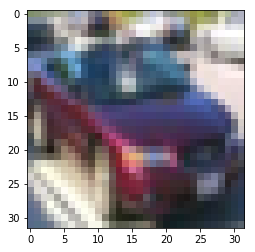

In [18]:
hidden_units = [100, 100, 100, 10]
if dataset == 'MNIST':
    x = tf.placeholder(tf.float32, [1, 28, 28])
    classes = ['Zero', 'One', 'Two', 'Three', 'Four', 'Five',
              'Six', 'Seven', 'Eight', 'Nine']
elif dataset == 'CIFAR10':
    x = tf.placeholder(tf.float32, [1, 32, 32, 3])
    classes = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
              'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
#parameters = init_four_layer_FC(784, hidden_units)
# Add scores
scores = four_layer_FC(PIXELS, x, updated_parameters,dataset)    
#eval_op = tf.nn.top_k(scores)

idx = np.random.randint(10000)

init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    if dataset=='MNIST':
        scores2 = sess.run(scores, feed_dict={x:x_test[idx].reshape(1, 28, 28)})
    else:
        scores2 = sess.run(scores, feed_dict={x:x_test[idx].reshape(1, 32, 32, 3)})
        
    print('The predicted class is: ', classes[np.argmax(scores2)])
    plt.imshow(x_test[idx].astype(np.int32))

## Load the previously trained model

So far we have trained the complete model, computed its accuracy, and validated it with random samples. However, we did the whole process in one go. Since the dataset is relatively simple this is not an issue, nonetheless this would be prohibiting for more complex and larger datasets. Since we saved our trained model, we can just load it and test it.

INFO:tensorflow:Restoring parameters from checkpoint_file
The predited number is:  Horse


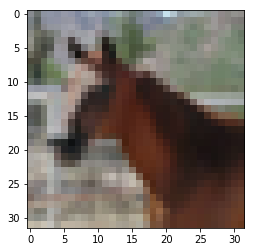

In [22]:
if dataset == 'MNIST':
    x = tf.placeholder(tf.float32, [1, 28, 28])
    classes = ['Zero', 'One', 'Two', 'Three', 'Four', 'Five',
              'Six', 'Seven', 'Eight', 'Nine']
elif dataset == 'CIFAR10':
    x = tf.placeholder(tf.float32, [1, 32, 32, 3])
    classes = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
              'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

with tf.Session() as sess2:
    # Load saved Model
    saver = tf.train.import_meta_graph('checkpoint_file.meta')
    saver.restore(sess2, 'checkpoint_file')
    
    # Load saved points
    # Scores includes the complete model, with final parameters
    scores = tf.get_collection('scores')[0]
    # Saved placeholders, since we only want to run the inference graph, we only load x
    x = tf.get_collection('images')[0]
    
    # Choose radom point in test data
    idx = np.random.randint(10000)
    plt.imshow(x_test[idx].astype(np.int32))
    
    # Calculate the score
    if dataset=='MNIST':
        scores2 = sess2.run(scores, feed_dict={x:x_test[idx].reshape(1, 28, 28)})
    else:
        scores2 = sess2.run(scores, feed_dict={x:x_test[idx].reshape(1, 32, 32, 3)})
        
    print('The predited number is: ', classes[np.argmax(scores2)])
